In [1]:
epochs, batch_size, learning_rate = 100, 64, 0.0001

In [2]:
from torch.nn import Module, Conv1d, Linear, ReLU, Sigmoid, Sequential, Flatten, Unflatten, BCELoss
from torch.optim import Adam

class BinaryEncoderConvolution(Module):

    def __init__(self, initial_length = 100, convolutions = [3, 3], linear_layers = [64]):
        super().__init__()
        pre_linear_length = (2 ** len(convolutions)) * (initial_length - 2 * len(convolutions))
        self.layers = Sequential(
                Unflatten(dim=1, unflattened_size=(1, initial_length)),
                *[Conv1d(in_channels=2**idx, out_channels=2 * (2**idx), kernel_size=kernel) for idx, kernel in enumerate(convolutions)],
                Flatten(),
                Sequential(Linear(pre_linear_length, linear_layers[0]), ReLU()),
                *[Sequential(Linear(l1, l2), ReLU()) for l1, l2 in zip(linear_layers, linear_layers[1:])],
                Linear(linear_layers[-1], 1),
                Sigmoid()
        )
    

    def forward(self, word):
        return self.layers(word)

model = BinaryEncoderConvolution(initial_length=50, convolutions=[3, 3, 3], linear_layers= [32, 16])
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = BCELoss()


In [3]:
from pathlib import Path
from core.generators import ClosureGenerator, ChoiceGenerator
from data.utils import create_dataset, convert_word_pad_one_side, convert_labels, columns_of_subgroups
from data.free_group_dataset import FreeGroupDataset

name = '2-generators;balanced'

def dataset():
    path = Path('data', 'datasets', name)
    if not path.is_dir():
        gen1 = ChoiceGenerator(
            (ClosureGenerator(generators_number=2, length_config={'max-length': 50}), 0.7),
            (ClosureGenerator(generators_number=2, length_config={'max-length': 20}), 0.3)
        )
        gen2 = ChoiceGenerator(
            (ClosureGenerator(generators_number=2, length_config={'max-length': 50}, subgroup=[1]), 0.7),
            (ClosureGenerator(generators_number=2, length_config={'max-length': 20}, subgroup=[1]), 0.3)
        )
        create_dataset(
            generator=ChoiceGenerator((gen1, 0.5), (gen2, 0.5)).take(100_000),
            columns=columns_of_subgroups(0b01),
            path_or_name=path
        )
    return FreeGroupDataset(source=path, word_convert=convert_word_pad_one_side(50), labels_convert=convert_labels())

In [3]:
from torch.utils.data import DataLoader
from torch import tensor, LongTensor
from tqdm.notebook import tqdm
from torchmetrics import Accuracy
from torch import save, load
from pathlib import Path

p = Path('models', 'binary')
p.mkdir(parents=True, exist_ok=True)

need_load = True

if need_load == True:
    with open(p / '100', 'rb') as f:
        model.load_state_dict(load(f))
    model.eval()
else:
    model.train()
    ds = dataset()
    accuracy = Accuracy(multiclass = False)

    for e in range(1, epochs + 1):
        epoch_loss, epoch_accuracy = 0, []
        for X_batch, y_batch in tqdm(DataLoader(ds, batch_size=batch_size, shuffle=True)):
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_accuracy.append(accuracy(y_pred.squeeze(), y_batch.squeeze().type(LongTensor)))
        print(f'Epoch: {e:03d} \t Loss: {epoch_loss:0.3f} \t Accuracy: {tensor(epoch_accuracy).mean(dim=0):0.3f}')
        
        with open(p / str(e), 'wb') as f:
            save(model.state_dict(), f)


In [4]:
from torchmetrics import Accuracy, Precision, Recall
from data.utils import convert_word_pad_one_side, convert_labels, columns_of_subgroups
from core.free_group import is_in_subgroup
from torch import stack, int as tint

accuracy, precision, recall = Accuracy(multiclass=False), Precision(multiclass=False), Recall(multiclass=False)
word_converter, labels_converter = convert_word_pad_one_side(length=50), convert_labels(dtype=tint)

def evaluate(generator, metrics = [accuracy, precision, recall]):
    words = list(generator)
    y_pred = model(
        stack([word_converter(w) for w in words], dim=0)
    )
    y_true = labels_converter([is_in_subgroup([1], w) for w in words])
    
    return [m(y_pred.squeeze(), y_true.squeeze()) for m in metrics]



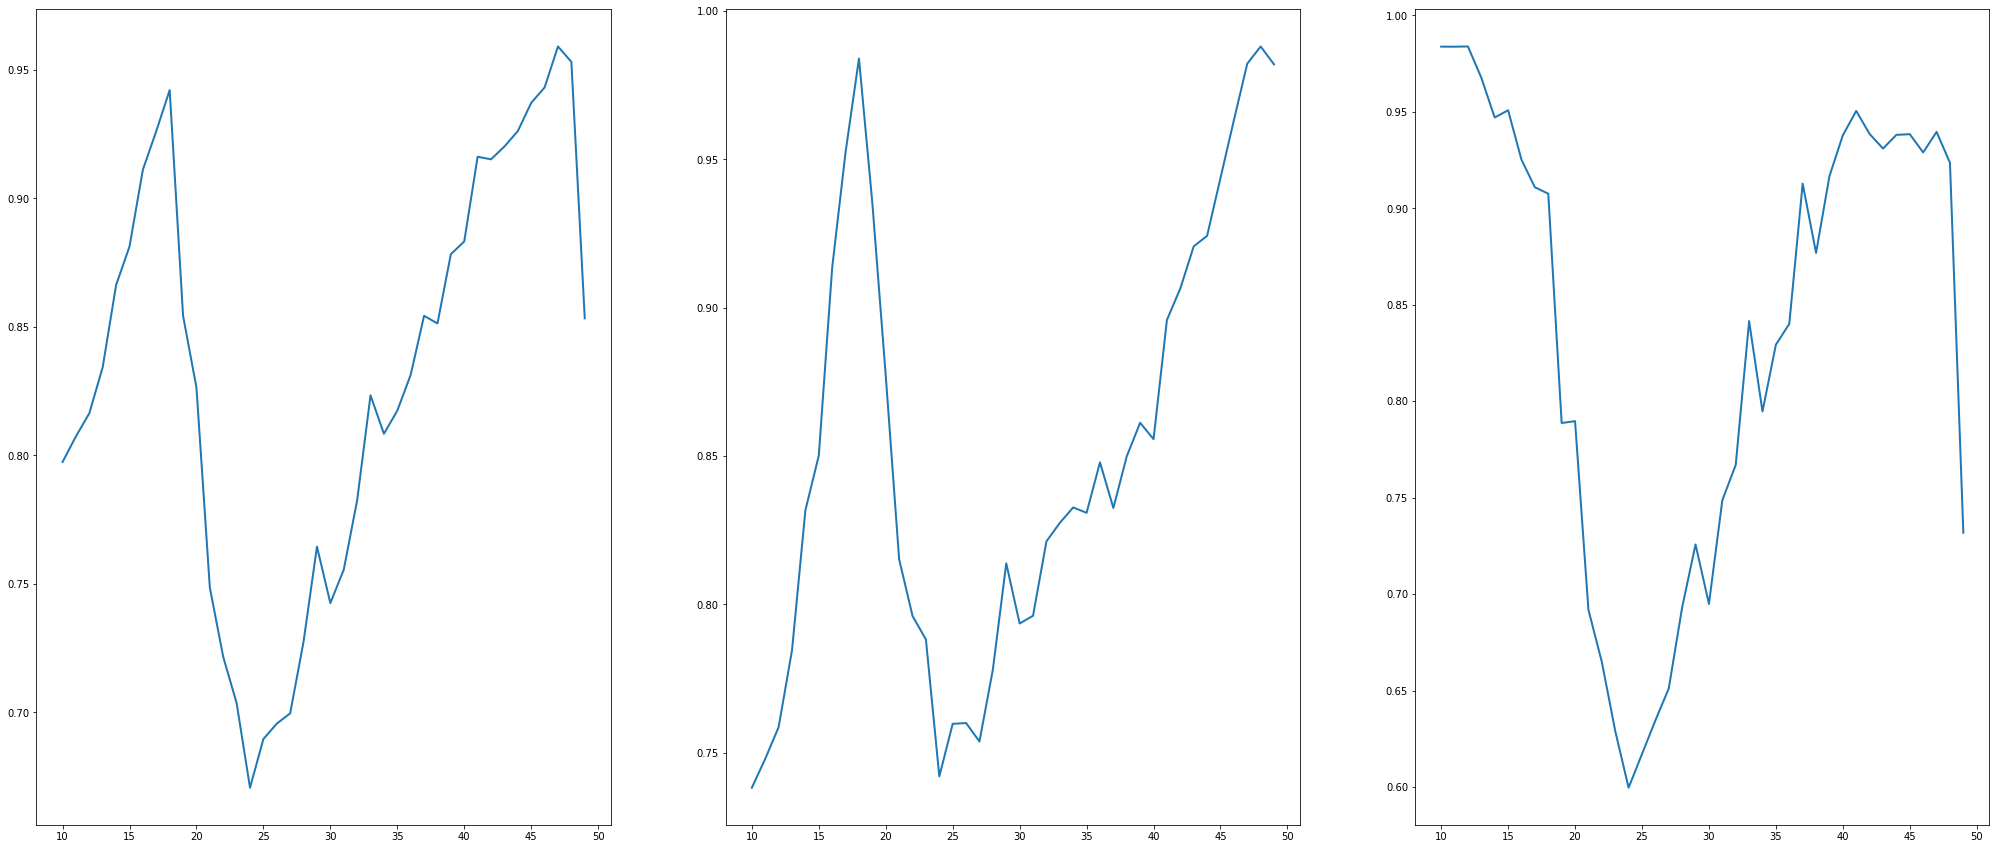

In [14]:
import matplotlib.pyplot as plt


x = range(10, 50)
y1, y2, y3 = zip(*[evaluate(SequenceGenerator(
        ClosureGenerator(generators_number=2, length_config={'length': l}).take(500),
        ClosureGenerator(generators_number=2, length_config={'length': l}, subgroup=[1]).take(500)
)) for l in x])

fig, ax = plt.subplots(ncols=3, figsize=(35, 15))

ax[0].plot(x, y1, linewidth=2.0)
ax[1].plot(x, y2, linewidth=2.0)
ax[2].plot(x, y3, linewidth=2.0)



plt.show()
